# Notebook Instructions
<i>You can run the notebook document sequentially (one cell at a time) by pressing <b> shift + enter</b>. While a cell is running, a [*] will display on the left. When it has been run, a number will display indicating the order in which it was run in the notebook [8].</i>

<i>Enter edit mode by pressing <b>`Enter`</b> or using the mouse to click on a cell's editor area. Edit mode is indicated by a green cell border and a prompt showing in the editor area.</i> <BR>
    
This course is based on specific versions of python packages. You can find the details of the same in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>. The manual also explains how to use these codes in other versions of python packages. <BR>

# Turn of the Month Effect

## Strategy overview

The turn of the month is a well-known effect on stock indexes, with a simple idea that equity prices usually increase during the last four days and the first three days of each month. Research conducted over the years identified such a pattern for multiple periods, both in the Dow Jones Industrial Average and the S&P500 index. In this strategy, we buy the SPY ETF on close at the end of the month and sell it on close of the first day in the following month.

Also, there is an option to lower maximal drawdown. The solution is to add the trend factor in the strategy. One of the simplest ways to do it is to trade only if the price of SPY is higher than it's 200-day average.

## Notebook navigation

1. Read SPY data
2. Generate trading signals
3. Calculate strategy returns
4. Calculate drawdown
5. Add trend factor

## Read SPY data

To read the CSV file, we use "pandas.read_csv()".

Syntax: 

<b>pd.read_csv(filename)</b>

filename: Name of the file in the string format

This data is available in the downloadable unit of this course in the last section. You can also download SPY adjusted close data from finance.yahoo.com.

In [1]:
# Import pandas
import pandas as pd

# Read SPY prices
spy_prices = pd.read_csv('../data/spy_prices.csv', delimiter=';')

# Convert Date column to date-time format
spy_prices.Date = pd.to_datetime(spy_prices.Date)

# Calculate daily changes of the adjusted close price
spy_prices['daily_changes'] = spy_prices['Adjusted Close'].pct_change()

spy_prices.tail()

,Date,Open,High,Low,Close,Adjusted Close,Volume,daily_changes
6806,2020-02-10,331.230011,334.750000,331.190002,334.679993,334.679993,42070000,0.007465
6807,2020-02-11,336.160004,337.019989,334.679993,335.260010,335.260010,54864500,0.001733
6808,2020-02-12,336.829987,337.649994,336.429993,337.420013,337.420013,43992700,0.006443
6809,2020-02-13,335.859985,338.119995,335.559998,337.059998,337.059998,54501900,-0.001067
6810,2020-02-14,337.510010,337.730011,336.200012,337.600006,337.600006,64524200,0.001602


## Generate trading signals


### Turn of the month signal

To "backtest" this strategy, we need to generate trading signals.

We place a value of 1 in place of the first day of every month. This is done by comparing the month of the current date with the month of the previous date.

We use `where()` function from NumPy to do this.

Syntax:

<b>numpy.where(condition,x,y)</b> 

Parameters 

Condition: Condition to check

x: Value if the condition is satisfied 

y: Value If the condition is not satisfied

In [2]:
# Import numpy
import numpy as np

# Generate turn of the month signal
spy_prices['turn_of_month_signal'] = np.where(spy_prices.Date.dt.month != spy_prices.Date.dt.month.shift(1), 1, 0)

# Set Date column as index
spy_prices.set_index('Date', inplace=True)
spy_prices.tail()

,Open,High,Low,Close,Adjusted Close,Volume,daily_changes,turn_of_month_signal
Date,,,,,,,,
2020-02-10,331.230011,334.750000,331.190002,334.679993,334.679993,42070000,0.007465,0
2020-02-11,336.160004,337.019989,334.679993,335.260010,335.260010,54864500,0.001733,0
2020-02-12,336.829987,337.649994,336.429993,337.420013,337.420013,43992700,0.006443,0
2020-02-13,335.859985,338.119995,335.559998,337.059998,337.059998,54501900,-0.001067,0
2020-02-14,337.510010,337.730011,336.200012,337.600006,337.600006,64524200,0.001602,0


## Calculate strategy returns

To calculate strategy returns, multiply daily_changes with turn_of_month_signal. Then, we use `cumprod()` function to calculate cumulative strategy returns.

In [3]:
# Calculate strategy returns
spy_prices['strategy_returns'] = spy_prices['daily_changes'] * spy_prices['turn_of_month_signal']

# Calculate cumulative strategy returns
cumulative_strategy_returns = ((spy_prices['strategy_returns'] + 1).cumprod())

# Calculate strategy returns
total_strategy_returns = (cumulative_strategy_returns.iloc[-1]-1)*100
print("The strategy returns is %.2f" % total_strategy_returns)

The strategy returns is 112.70


In [4]:
# Total number of trading days
days = len(cumulative_strategy_returns)

# Calculate compounded annual growth rate
cagr = (cumulative_strategy_returns.iloc[-1]**(252/days)-1)*100
print('The CAGR from strategy is %.2f' % cagr)

The CAGR from strategy is 2.83


### Plotting 

To plot strategy returns, we need to `import matplotlib.pyplot` library and use `plot()` function. Next, we add labels to the chart.

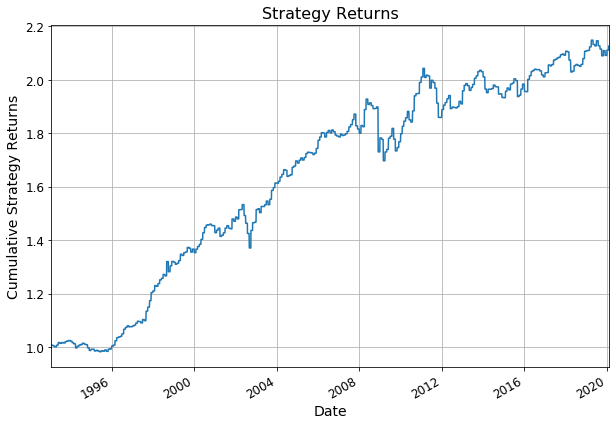

In [5]:
# Import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


def plot_strategy_returns(cumulative_strategy_returns):

    # Plot cumulative strategy returns
    plt.figure(figsize=(10, 7))
    cumulative_strategy_returns.plot()
    plt.grid()

    # Define label for the title of the figure
    plt.title('Strategy Returns', fontsize=16)

    # Define labels for x-axis and y-axis
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Cumulative Strategy Returns', fontsize=14)

    # Define the tick size for x-axis and y-axis
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.show()


plot_strategy_returns(cumulative_strategy_returns)

## Calculate drawdown

Drawdown can be defined as the percentage loss from the highest cumulative historical point.

The formula to calculate drawdown:

<b>Drawdown = (cumulative returns/ running maximum) - 1</b>

To calculate the running maximum, we can use `maximum()` and `accumulate()` functions

In [6]:
def calc_drawdown(cum_rets):

    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())

    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1

    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1
    return drawdown


drawdown = calc_drawdown(cumulative_strategy_returns)
max_dd = drawdown.min()*100

print("The maximum drawdown is %.2f" % max_dd)

The maximum drawdown is -11.97


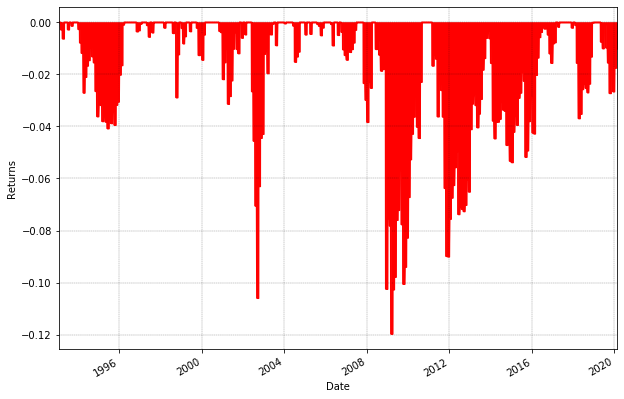

In [7]:
def plot_drawdown(drawdown):

    # Plot drawdown
    plt.figure(figsize=(10, 7))
    drawdown.plot(color='r')
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown.values, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()


plot_drawdown(drawdown)

------------------------------------------------------------------------------------
## Add trend factor
### Moving average filter

We use a simple moving average to filter our trading signals. Only if the price of SPY is above 200 period SMA, we will hold our position.

For this, we use the `rolling()` function of DataFrame to compute the moving average of the price series. 

Syntax:<br>
<b>DataFrame.rolling(window).mean()</b>

Parameters:

window: number of observations used to calculate the statistics.<br>

Then, we calculate our SMA signal. We use `where()` function of Numpy to compare shifted SPY prices and SMA values. We use shift because we need to know if the price was above SMA at the close of the previous day. If the price is above SMA value, place value of 1 to our SMA signal.

In [8]:
# Import numpy
import numpy as np

# Calculate 200-day rolling mean of spy close prices
spy_prices['sma_200'] = spy_prices['Adjusted Close'].rolling(window=200).mean()

# Generate SMA signals
spy_prices['sma_signal'] = np.where(
    spy_prices['Adjusted Close'].shift(1) > spy_prices['sma_200'].shift(1), 1, 0)

spy_prices.tail()

,Open,High,Low,Close,Adjusted Close,Volume,daily_changes,turn_of_month_signal,strategy_returns,sma_200,sma_signal
Date,,,,,,,,,,,
2020-02-10,331.230011,334.750000,331.190002,334.679993,334.679993,42070000,0.007465,0,0.0,299.885975,1
2020-02-11,336.160004,337.019989,334.679993,335.260010,335.260010,54864500,0.001733,0,0.0,300.116147,1
2020-02-12,336.829987,337.649994,336.429993,337.420013,337.420013,43992700,0.006443,0,0.0,300.354851,1
2020-02-13,335.859985,338.119995,335.559998,337.059998,337.059998,54501900,-0.001067,0,-0.0,300.591017,1
2020-02-14,337.510010,337.730011,336.200012,337.600006,337.600006,64524200,0.001602,0,0.0,300.840774,1


In [9]:
# Calculate strategy returns with trend factor
spy_prices['strategy_returns_trend_factor'] = spy_prices['daily_changes'] * spy_prices['turn_of_month_signal'] \
    * spy_prices['sma_signal']

# Calculate cumulative strategy returns with trend factor
cumulative_strategy_returns_trend_factor = (
    (spy_prices['strategy_returns_trend_factor']+1).cumprod())

# Calculate strategy returns with trend factor
total_strategy_returns_trend_factor = (
    cumulative_strategy_returns_trend_factor.iloc[-1]-1)*100

print("The strategy returns is %.2f" % total_strategy_returns_trend_factor)

The strategy returns is 117.96


In [10]:
# Total number of trading days
days = len(cumulative_strategy_returns_trend_factor)

# Calculate CAGR with trend factor
cagr_trend_factor = (
    cumulative_strategy_returns_trend_factor.iloc[-1]**(252/days)-1)*100

print('The CAGR from strategy is %.2f' % cagr_trend_factor)

The CAGR from strategy is 2.92


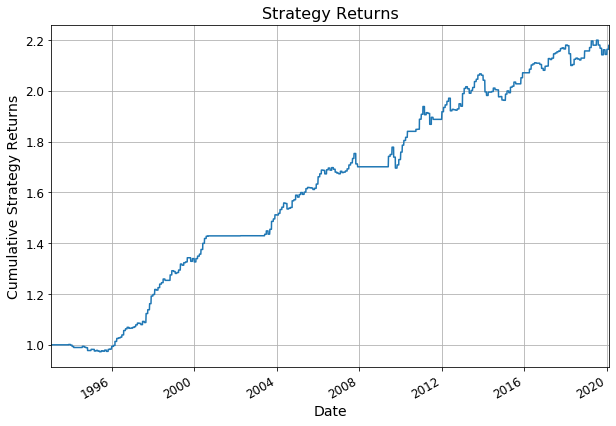

In [11]:
plot_strategy_returns(cumulative_strategy_returns_trend_factor) 

In [12]:
# Calculate drawdown with trend factors
drawdown = calc_drawdown(cumulative_strategy_returns_trend_factor)
max_dd_trend_factor = drawdown.min()*100

print("The maximum drawdown is %.2f" % max_dd_trend_factor)

The maximum drawdown is -5.04


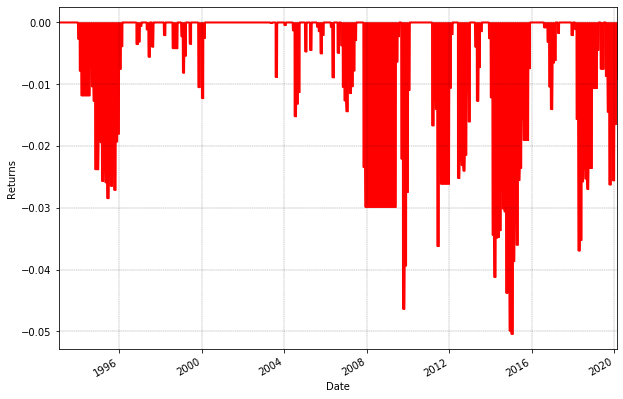

In [13]:
plot_drawdown(drawdown)

## Performance summary

In [14]:
# Import tabulate
from tabulate import tabulate

stats = tabulate(
        [
            ['Strategy Returns', total_strategy_returns, total_strategy_returns_trend_factor],
            ['CAGR', cagr, cagr_trend_factor],
            ['Maximum Drawdown', max_dd, max_dd_trend_factor],
            ['CAGR/Maximum Drawdown', cagr/abs(max_dd), cagr_trend_factor/abs(max_dd_trend_factor)],
        ],
        headers=['Stats Name','Strategy', 'Strategy with Trend Factor'], tablefmt='orgtbl')

print(stats)

| Stats Name            |   Strategy |   Strategy with Trend Factor |
|-----------------------+------------+------------------------------|
| Strategy Returns      | 112.7      |                   117.956    |
| CAGR                  |   2.83171  |                     2.92463  |
| Maximum Drawdown      | -11.9677   |                    -5.03764  |
| CAGR/Maximum Drawdown |   0.236613 |                     0.580556 |


## Conclusion

The yearly performance of the strategy is 2.8%, and maximum drawdown is -11.96%. After applying the trend filter, both CAGR returns and maximum drawdown improves.

In the next section, you will learn about the payday effect in equity markets. <br><br>